In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from scipy import signal
from scipy.fftpack import fft, ifft, dct, idct
from scipy.linalg import dft

import tensorflow as tf


import MEArec as mr
import MEAutility
import spikeinterface as si
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import spikeinterface.sorters as ssort
import spikeinterface.widgets as sw

import warnings
warnings.filterwarnings("ignore")

2022-07-09 19:20:27.739714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 19:20:27.739758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
## 1D stft from scratch

# def stft_hann(data, fft_size):
#     hop_size = fft_size//4
#     total_segments = np.int32(np.ceil(data.shape[-1] / np.float32(hop_size)))
#     window = np.hanning(fft_size)
#     proc = np.concatenate((data, np.zeros(fft_size))) #padding end of data 
#     result = np.empty((total_segments, fft_size), dtype=np.float32)    
#     for i in range(total_segments):                      
#         current_hop = hop_size * i                        
#         segment = proc[current_hop:current_hop+fft_size]  
#         windowed = segment * window                      
#         padded = np.append(windowed, np.zeros(fft_size))           
#         spectrum = np.fft.fft(padded) / np.sqrt(fft_size)
#         result[i, :] = spectrum[:fft_size]
#     return result

In [4]:
# pooling t highest coefficients of x matrix

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

In [5]:
# Input: 
# RIC, signal length (l), sparsity level (k)
# Output: # measurements, RIP satisfiable probability    

def pre_rip(k1, delta, l, k):  
    # k1: arbiteraty but, we need to choose it large enough to have atleast 10% measurements over all length
    # as it affects the number of measurements that should apply to have RIP measurement matrix so, we 
    # need to tune it as a hyperparameter
    
    #k_star
    k_star = 2/(1-np.log(2))
    # k2
    k2 = delta**2 / (2*k_star) - 1 / (k1*np.log(42*np.e / delta))
    # number of measurements
    nm = int( round(k1*k*np.log(l/k) ) )
    # probability of RIP satisfaction
    p = 1 - 2*np.exp(k2*nm)
    return nm, p

In [6]:
# input: # measurements, # channels, temporal window size, starting and ending window positions
# output: transform matrix (phi) from data to measurements, measurements vector (y), spatiotemporal DFT

def cs_matrices(nm, nch, win_size, start_win, end_win):
    df_time = dft(win_size, 'sqrtn')
    df_space = dft(nch, 'sqrtn')
    df = np.kron(df_space, df_time)
    M = np.random.uniform(0, 1/np.sqrt(nm), (nm,win_size*nch))
    phi = np.dot(M, np.conjugate(df).T)
    y = np.dot(M, v1[:,start_win:end_win].reshape(-1))
    return phi, y, df

In [7]:
# padding data with pad_size

def pad(v, pad_size):
    v_pad = np.zeros((nch, len(v[1])+pad_size))
    for k1 in range(nch):
        v_pad[k1,:] = np.pad(v[k1,:], (0, pad_size),
                    mode='constant', constant_values=0)
    return v_pad

In [8]:
# reading recording into numpy array

c = 10 #cell population
k = 0 # config
recording, gt = se.read_mearec('data/MEA10*10/recgen_cell_%s/%s.h5'%(c,k))
sv = recording.get_traces().T


### build a pipline for recordings

In [9]:
# init: recording data, window ( for example: boxcar, hann, ...), hop: hoppingsize, pad_len: length of padding
# window, hopping, and padding should compatible with eachother to adjust start and ending process.

# win_gen: generate batches with input window

# win_set: generate a dataset of windowed batches

class Windowing:
    def __init__(self, recording, window, hop, pad_len):
        self.v = recording
        self.w = window
        self.h = hop
        self.pl = pad_len
    
    def win_gen(self):
        nch, ns = self.v.shape
        m = ns//len(self.w)
        for i in range(m):
            ss = np.pad(self.v[:, i*self.h:i*self.h+len(self.w)]*self.w,
                   (0, self.pl), mode='constant', constant_values=0)
            yield ss
            
    def win_set(self):
        nch, ns = self.v.shape
        d = tf.data.Dataset.from_generator(self.win_gen, 
                                              output_types=tf.float32, 
                                              output_shapes=(nch,len(self.w)))
        return d

In [10]:
# init: d: windowed dataset, m: measurement matrix, phi: transformed matrix, k_sparse

# cs_gen: generate the Model based signal recovery (OMP or LARS) for each batch

# cs_recovery: build a dataset of recovered signal

class CSOMP:
    def __init__(self, d, m, phi, k_sparse):
        self.d = d
        self.m = m
        self.phi = phi
        self.k = k_sparse    

    def cs_gen(self):

        for w in self.d:
            y = np.dot(m, w.numpy().reshape(-1))
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs=k_sparse, normalize=False)
            omp.fit(phi.real, y)
            coef_omp_real = omp.coef_ 
            omp.fit(phi.imag, y)
            coef_omp_img = omp.coef_ 
            coef_omp = coef_omp_real + 1j*coef_omp_img   
            yield coef_omp
            
    def cs_recovery(self):
        d = tf.data.Dataset.from_generator(self.cs_gen, 
                                              output_types=tf.complex64)
        return d
        

In [11]:
win_size = 100
hop = win_size # for now let's just consider no overlapping
win = signal.windows.boxcar(win_size, sym=True) # using simple boxcar window
pl = 0
rec = sv[:,1000:2000] # the all data sv can feed to the pipline
nch, ns = rec.shape
d = Windowing(rec, win, hop, pl).win_set()
print(d)

<FlatMapDataset element_spec=TensorSpec(shape=(100, 100), dtype=tf.float32, name=None)>


2022-07-09 19:20:36.008526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-09 19:20:36.008615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 19:20:36.008656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bs-hierlemann09): /proc/driver/nvidia/version does not exist
2022-07-09 19:20:36.009249: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# test: to see the data in dataset and original recordings are same

v_test = np.zeros((nch,ns))
for i, elm in enumerate(d):
    v_test[:,i*win_size:(i+1)*win_size]=elm

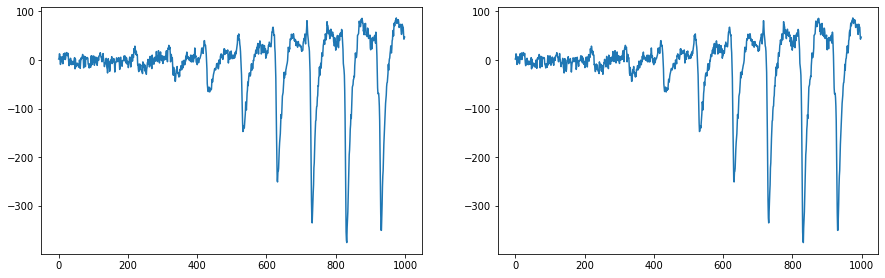

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(v_test[40:50,100:200].reshape(-1))

<AxesSubplot:>

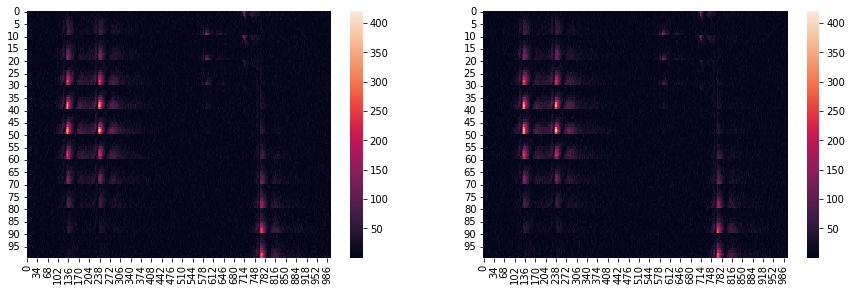

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(v_test))

In [15]:
k1 = 1
k = nch*win_size//100
delta = .5
l = nch*win_size
nm, p = pre_rip(k1, delta, l, k)
print('# of measurements = %s or %s %%'%(nm, 100*nm/(nch*win_size)))
print('probability of satisfiable RIP = ', p)

# of measurements = 461 or 4.61 %
probability of satisfiable RIP =  1.0


In [16]:
df = dft(nch*win_size, 'sqrtn')
m = np.random.uniform(0, 1/np.sqrt(nm), (nm, nch*win_size))
phi = np.dot(m, np.conjugate(df).T)
print('dft shape: ',df.shape)
print('M shape: ',m.shape)
print('phi shape: ',phi.shape)

dft shape:  (10000, 10000)
M shape:  (461, 10000)
phi shape:  (461, 10000)


In [17]:
k_sparse = nch*win_size//100
csomp = CSOMP(d, m, phi, k_sparse)
mr = csomp.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [18]:
vomp = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vomp[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

epoch-----------0
epoch-----------1
epoch-----------2
epoch-----------3
epoch-----------4
epoch-----------5
epoch-----------6
epoch-----------7
epoch-----------8
epoch-----------9


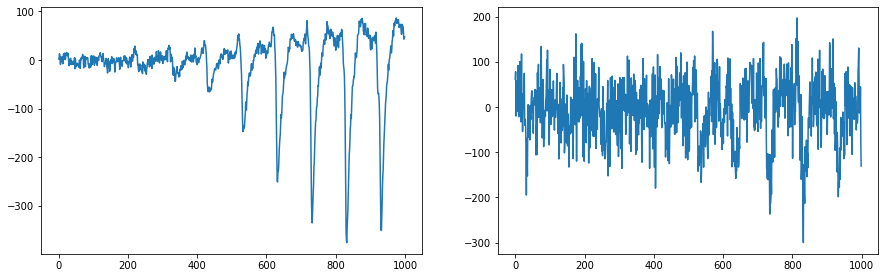

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(vomp[40:50,100:200].reshape(-1))

<AxesSubplot:>

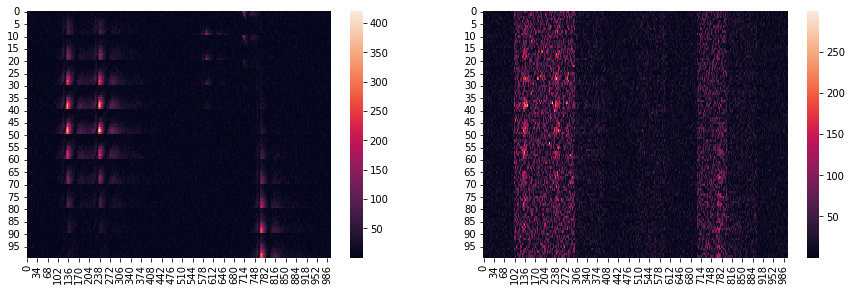

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(vomp))

### same recovery with LARS:

In [21]:
class CSLARS:
    def __init__(self, d, m, phi, k_sparse):
        self.d = d
        self.m = m
        self.phi = phi
        self.k = k_sparse    

    def cs_gen(self):

        for w in self.d:
            y = np.dot(m, w.numpy().reshape(-1))
            lars = Lars(n_nonzero_coefs=k_sparse, normalize=False)
            lars.fit(phi.real, y)
            coef_lars_real = lars.coef_ 
            lars.fit(phi.imag, y)
            coef_lars_img = lars.coef_ 
            coef_lars = coef_lars_real + 1j*coef_lars_img   
            yield coef_lars
            
    def cs_recovery(self):
        d = tf.data.Dataset.from_generator(self.cs_gen, 
                                              output_types=tf.complex64)
        return d

In [22]:
k_sparse = nch*win_size//100
cslars = CSLARS(d, m, phi, k_sparse)
mr = cslars.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [23]:
vlars = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vlars[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

epoch-----------0
epoch-----------1
epoch-----------2
epoch-----------3
epoch-----------4
epoch-----------5
epoch-----------6
epoch-----------7
epoch-----------8
epoch-----------9


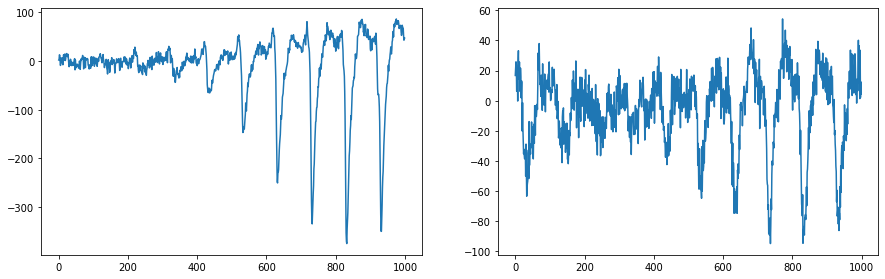

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(vlars[40:50,100:200].reshape(-1))

<AxesSubplot:>

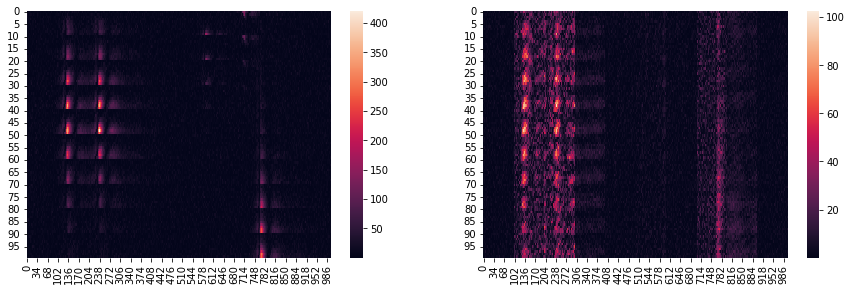

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(vlars))

### NeuroPixels-384

In [26]:
# recordings_params = mr.get_default_recordings_params()
# recordings_params['spiketrains']['duration'] = 60
# recordings_params['recordings']['noise_level'] = 5
# recordings_params['spiketrains']['n_exc'] = 22
# recordings_params['spiketrains']['n_inh'] = 8
# recordings_params['seeds']['spiketrains'] = 12
# recordings_params['seeds']['templates'] = 23
# recordings_params['seeds']['noise'] = 34
# recordings_params['seeds']['convolution'] = 45
# recgen = mr.gen_recordings(params=recordings_params, templates='templates_100_Neuropixels-384.h5')
# mr.save_recording_generator(recgen, 'recordings_100_Neuropixels-384.h5')

In [27]:
# we = si.extract_waveforms(recording, gt, 'tmp', overwrite=True)
# sw.plot_unit_localization(we)

In [28]:
recording, gt = se.read_mearec('recordings_100_Neuropixels-384.h5')
sv = recording.get_traces().T

In [29]:
win_size = 100
hop = win_size # for now let's just consider no overlapping
win = signal.windows.boxcar(win_size, sym=True)
pl = 0
rec = sv[:,3500:4500]
nch, ns = rec.shape
d = Windowing(rec, win, hop, pl).win_set()
print(d)

<FlatMapDataset element_spec=TensorSpec(shape=(384, 100), dtype=tf.float32, name=None)>


In [30]:
v_test = np.zeros((nch,ns))
for i, elm in enumerate(d):
    v_test[:,i*win_size:(i+1)*win_size]=elm

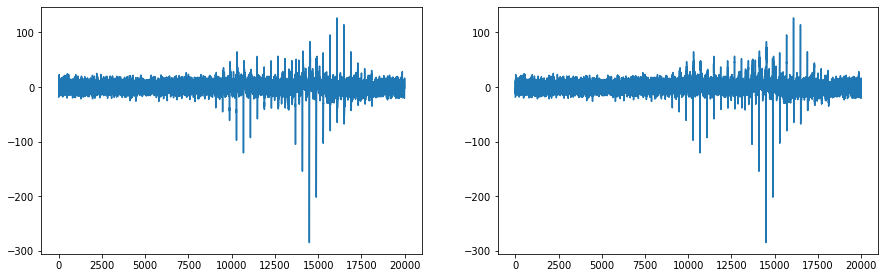

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[50:100,100:500].reshape(-1))
plt.subplot(222)
plt.plot(v_test[50:100,100:500].reshape(-1))

<AxesSubplot:>

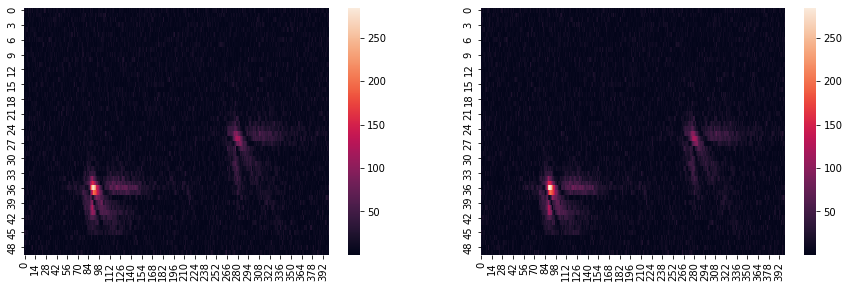

In [32]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec[50:100,100:500]))
plt.subplot(222)
sns.heatmap(abs(v_test[50:100,100:500]))

In [33]:
k1 = 1
k = nch*win_size//100
delta = .5
l = nch*win_size
nm, p = pre_rip(k1, delta, l, k)
print('# of measurements = %s or %s %%'%(nm, 100*nm/(nch*win_size)))
print('probability of satisfiable RIP = ', p)

# of measurements = 1768 or 4.604166666666667 %
probability of satisfiable RIP =  1.0


In [34]:
df = dft(nch*win_size, 'sqrtn')
m = np.random.uniform(0, 1/np.sqrt(nm), (nm, nch*win_size))
phi = np.dot(m, np.conjugate(df).T)
print('dft shape: ',df.shape)
print('M shape: ',m.shape)
print('Phi shape: ',phi.shape)

dft shape:  (38400, 38400)
M shape:  (1768, 38400)
Phi shape:  (1768, 38400)


In [35]:
k_sparse = nch*win_size//100
csomp = CSOMP(d, m, phi, k_sparse)
mr = csomp.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [36]:
vomp = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vomp[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

epoch-----------0
epoch-----------1
epoch-----------2
epoch-----------3
epoch-----------4
epoch-----------5
epoch-----------6
epoch-----------7
epoch-----------8
epoch-----------9


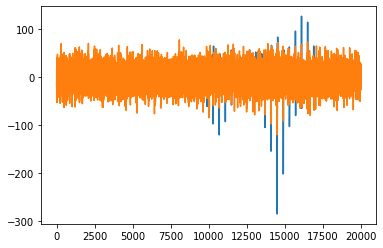

In [37]:
plt.plot(rec[50:100,100:500].reshape(-1))
plt.plot(vomp[50:100,100:500].reshape(-1))

<AxesSubplot:>

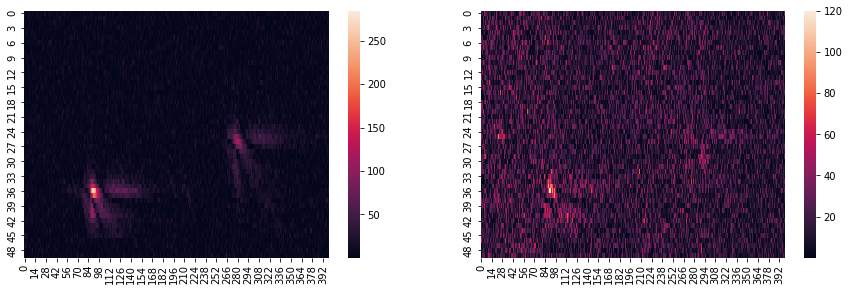

In [38]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec[50:100,100:500]))
plt.subplot(222)
sns.heatmap(abs(vomp[50:100,100:500]))

In [39]:
k_sparse = nch*win_size//100
cslars = CSLARS(d, m, phi, k_sparse)
mr = cslars.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [40]:
vlars = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vlars[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

epoch-----------0
epoch-----------1
epoch-----------2
epoch-----------3
epoch-----------4
epoch-----------5
epoch-----------6
epoch-----------7
epoch-----------8
epoch-----------9


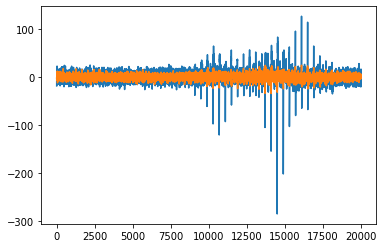

In [41]:
plt.plot(rec[50:100,100:500].reshape(-1))
plt.plot(vlars[50:100,100:500].reshape(-1))

<AxesSubplot:>

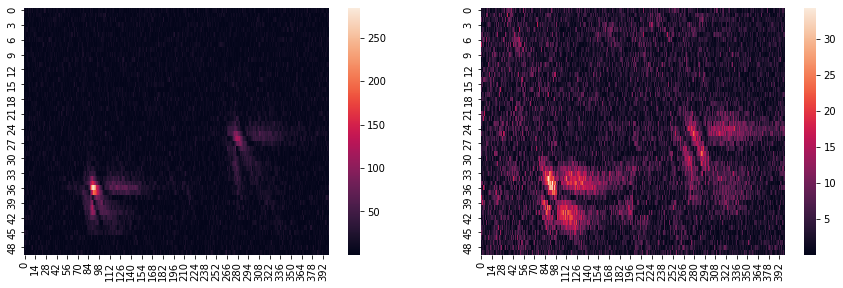

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec[50:100,100:500]))
plt.subplot(222)
sns.heatmap(abs(vlars[50:100,100:500]))